<a href="https://colab.research.google.com/github/linguo4/598sml-f22/blob/main/2D_inverse_elliptic_xPINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import numpy as np
import torch
import tensorboard, datetime
import matplotlib.pyplot as plt
from torch import nn
from tqdm import trange
%matplotlib inline

## PDE

$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f(x,y) \text{ for } x \in (0,1),  y \in (0,1)$

$u(x) = \sin(2\pi x)\sin(2\pi y)$

$f(x, y)$ is unknown, but we are given training samples $\{x_i, y_i, u_i\}$

## Training data

In [56]:
def u_true(x, y):
    return np.sin(2 * np.pi * x) * np.sin(2 * np.pi * y)
def f_true(x,y):
    return -8*(torch.pi)*(torch.pi)*torch.sin(torch.pi*x*2)*torch.sin(torch.pi*y*2)

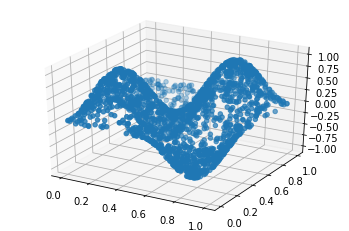

In [57]:
x_train = np.random.rand(2000)
y_train = np.random.rand(2000)
u_train = u_true(x_train, y_train)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train, y_train, u_train)

In [58]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=2):
        super().__init__()
        
        self.layer_first = nn.Linear(2, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 2)
        
    def forward(self, x, y):
        xt = torch.cat([x, y], dim=1)
        activation = nn.Tanh()
        u = activation(self.layer_first(xt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

In [59]:
## Loss = MSE(u - u_i) + MSE(r_i)
def loss_function_domain(model, x, y, u_true): 
    output = model(x, y)
    u = output[:, 0][:, None]
    f = output[:, 1][:, None]  
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    loss_res = torch.pow(u_xx+u_yy-f, 2).mean()
    loss = 1000* torch.pow(u-u_true, 2).mean()

    return loss_res+loss
  
def loss_function_interface(model_l, model_r, x, y): 
    output_l = model_l(x, y)
    u_l = output_l[:, 0][:, None]
    f_l = output_l[:, 1][:, None]  

    output_r = model_r(x, y)
    u_r = output_r[:, 0][:, None]
    f_r = output_r[:, 1][:, None]  

    u_avg = torch.div(torch.add(u_l, u_r), 2)
    loss_res = torch.pow(f_l-f_r, 2).mean()
    loss_l = 1000* torch.pow(u_l-u_avg, 2).mean()
    loss_r = 1000* torch.pow(u_r-u_avg, 2).mean()

    return loss_res+loss_l, loss_res+loss_r

def loss(model_l, model_r, x, y, x_bc, y_bc, u_true_l, u_true_r, left):
  loss_l, loss_r = loss_function_interface(model_l, model_r, x_bc, y_bc)
  if left:
    return loss_l + loss_function_domain(model_l, x, y, u_true_l)
  else:
    return loss_r + loss_function_domain(model_r, x, y, u_true_r)
    

## Decompose the domain to two parts (left&right)

In [60]:
n_train = 50
x = torch.linspace(0,1, n_train, requires_grad=True)
y_l = torch.linspace(0,0.5, n_train, requires_grad=True)
y_r = torch.linspace(0.5, 1, n_train, requires_grad=True)
x_m_l, y_m_l = torch.meshgrid(x, y_l)
x_l = x_m_l.reshape(-1, 1)
y_l = y_m_l.reshape(-1, 1)

x_m_r, y_m_r = torch.meshgrid(x, y_r)
x_r = x_m_r.reshape(-1, 1)
y_r = y_m_r.reshape(-1, 1)

x_bc = torch.linspace(0,1, n_train, requires_grad=True)
x_bc = x_bc.reshape(-1, 1)
y_bc = torch.add(torch.zeros_like(x_bc), 0.5)
u_l = torch.tensor(u_true(x_l.detach().numpy(),y_l.detach().numpy()), requires_grad=True)
u_r = torch.tensor(u_true(x_r.detach().numpy(),y_r.detach().numpy()), requires_grad=True)

In [64]:
torch.manual_seed(23939)
model_l = ffnn(15, 2)
model_r = ffnn(15, 2)

lr = 0.001
opt_l = torch.optim.Adam(model_l.parameters(), lr)
opt_r = torch.optim.Adam(model_r.parameters(), lr)
n_epochs = 30000

In [65]:
loss_history = []
for i in trange(n_epochs):
    loss_l = loss(model_l, model_r, x_l, y_l, x_bc, y_bc, u_l, u_r, True)
    opt_l.zero_grad()
    loss_l.backward()
    opt_l.step()
    loss_r = loss(model_l, model_r, x_r, y_r, x_bc, y_bc, u_l, u_r, False)
    opt_r.zero_grad()
    loss_r.backward()
    opt_r.step()
    loss_history.append([loss_l.item(), loss_r.item()])
    if i % 1000 == 0:
        print(f'epoch {i}, [left loss, right right loss] = {loss_l.item()},{loss_r.item()}')    

  0%|          | 4/30000 [00:00<16:01, 31.20it/s]

epoch 0, [left loss, right right loss] = 252.11373901367188,261.72900390625


  3%|▎         | 1006/30000 [00:26<11:11, 43.15it/s]

epoch 1000, [left loss, right right loss] = 88.81267547607422,85.89191436767578


  7%|▋         | 2007/30000 [00:52<10:55, 42.68it/s]

epoch 2000, [left loss, right right loss] = 30.4851016998291,31.78920555114746


 10%|█         | 3005/30000 [01:16<10:36, 42.41it/s]

epoch 3000, [left loss, right right loss] = 10.960962295532227,12.441744804382324


 13%|█▎        | 4007/30000 [01:40<10:18, 42.00it/s]

epoch 4000, [left loss, right right loss] = 3.8838930130004883,5.508458137512207


 17%|█▋        | 5005/30000 [02:05<12:14, 34.01it/s]

epoch 5000, [left loss, right right loss] = 2.2485876083374023,2.867323637008667


 20%|██        | 6006/30000 [02:30<11:19, 35.33it/s]

epoch 6000, [left loss, right right loss] = 1.269204020500183,1.6692339181900024


 23%|██▎       | 7006/30000 [02:56<11:42, 32.72it/s]

epoch 7000, [left loss, right right loss] = 1.0190839767456055,1.3271260261535645


 27%|██▋       | 8009/30000 [03:20<08:27, 43.34it/s]

epoch 8000, [left loss, right right loss] = 0.9551419019699097,1.1457141637802124


 30%|███       | 9006/30000 [03:45<08:54, 39.24it/s]

epoch 9000, [left loss, right right loss] = 0.8230839371681213,1.0342345237731934


 33%|███▎      | 10007/30000 [04:10<08:28, 39.31it/s]

epoch 10000, [left loss, right right loss] = 1.0711619853973389,1.1076440811157227


 37%|███▋      | 11005/30000 [04:34<07:31, 42.05it/s]

epoch 11000, [left loss, right right loss] = 0.9752073287963867,0.9757509827613831


 40%|████      | 12007/30000 [04:58<07:00, 42.76it/s]

epoch 12000, [left loss, right right loss] = 0.9369632005691528,1.2301357984542847


 43%|████▎     | 13005/30000 [05:23<07:01, 40.36it/s]

epoch 13000, [left loss, right right loss] = 0.7440256476402283,0.887567400932312


 47%|████▋     | 14007/30000 [05:47<06:47, 39.27it/s]

epoch 14000, [left loss, right right loss] = 0.666272759437561,0.791853666305542


 50%|█████     | 15007/30000 [06:12<05:32, 45.09it/s]

epoch 15000, [left loss, right right loss] = 0.569090723991394,0.7222686409950256


 53%|█████▎    | 16006/30000 [06:37<07:06, 32.80it/s]

epoch 16000, [left loss, right right loss] = 0.644474446773529,0.7596151232719421


 57%|█████▋    | 17007/30000 [07:01<04:59, 43.37it/s]

epoch 17000, [left loss, right right loss] = 0.7105816602706909,0.7964115142822266


 60%|██████    | 18007/30000 [07:25<05:36, 35.65it/s]

epoch 18000, [left loss, right right loss] = 0.5676777958869934,0.6558368802070618


 63%|██████▎   | 19007/30000 [07:50<04:15, 43.05it/s]

epoch 19000, [left loss, right right loss] = 0.5376425385475159,0.65364009141922


 67%|██████▋   | 20008/30000 [08:13<03:45, 44.37it/s]

epoch 20000, [left loss, right right loss] = 0.5095476508140564,0.6587379574775696


 70%|███████   | 21009/30000 [08:37<03:25, 43.75it/s]

epoch 21000, [left loss, right right loss] = 0.4891946315765381,0.6116041541099548


 73%|███████▎  | 22009/30000 [09:01<03:06, 42.94it/s]

epoch 22000, [left loss, right right loss] = 0.4869029223918915,0.600074052810669


 77%|███████▋  | 23009/30000 [09:25<02:38, 44.16it/s]

epoch 23000, [left loss, right right loss] = 0.5549659729003906,0.6571730971336365


 80%|████████  | 24007/30000 [09:50<02:44, 36.43it/s]

epoch 24000, [left loss, right right loss] = 0.4563942551612854,0.5557844638824463


 83%|████████▎ | 25009/30000 [10:16<02:02, 40.85it/s]

epoch 25000, [left loss, right right loss] = 1.1669526100158691,0.9224402904510498


 87%|████████▋ | 26009/30000 [10:40<01:31, 43.57it/s]

epoch 26000, [left loss, right right loss] = 0.44324105978012085,0.5302265286445618


 90%|█████████ | 27008/30000 [11:04<01:11, 41.79it/s]

epoch 27000, [left loss, right right loss] = 0.43475693464279175,0.5148568153381348


 93%|█████████▎| 28009/30000 [11:28<00:44, 44.37it/s]

epoch 28000, [left loss, right right loss] = 1.5544511079788208,0.9014643430709839


 97%|█████████▋| 29006/30000 [11:52<00:26, 38.00it/s]

epoch 29000, [left loss, right right loss] = 0.43378937244415283,0.5014306902885437


100%|██████████| 30000/30000 [12:16<00:00, 40.72it/s]


Text(0.5, 1.0, 'Loss for left and right domain')

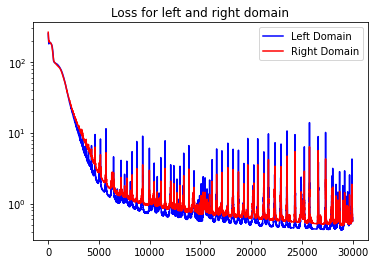

In [66]:
y1 = [x[0] for x in loss_history]
y2 = [x[1] for x in loss_history]
plt.yscale("log")
plt.plot(range(len(loss_history)), y1, "-b", label="Left Domain")
plt.plot(range(len(loss_history)), y2, "-r", label="Right Domain")
plt.legend()
plt.title("Loss for left and right domain")

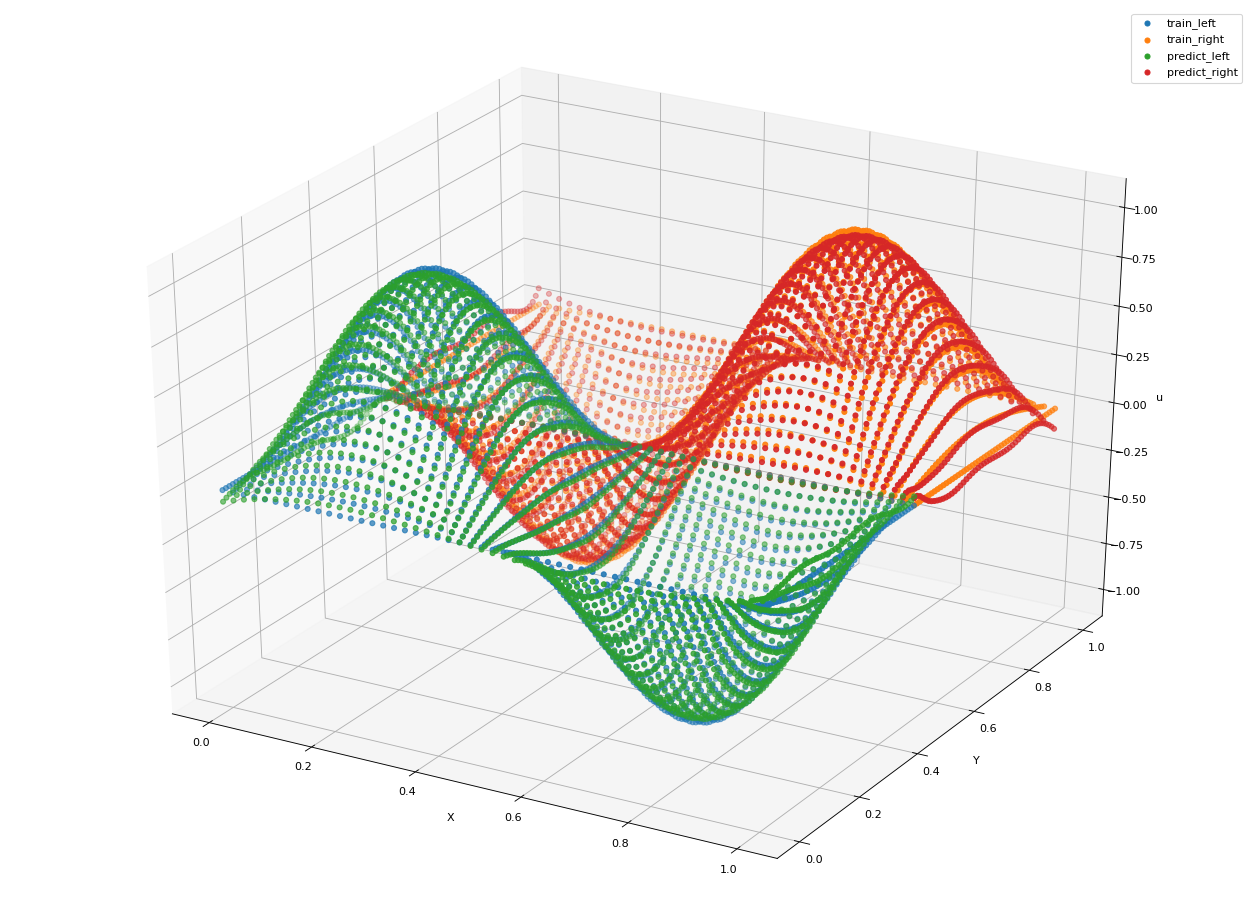

In [67]:
x_pl = x_l.detach().numpy()
y_pl = y_l.detach().numpy()
x_pr = x_r.detach().numpy()
y_pr = y_r.detach().numpy()

fig = plt.figure(figsize=(20, 15), dpi=80)
ax = fig.add_subplot(projection='3d')
ax.scatter(x_pl, y_pl, u_l.detach().numpy(), label = "train_left")
ax.scatter(x_pr, y_pr, u_r.detach().numpy(), label = "train_right")
ax.scatter(x_pl, y_pl, model_l(x_l,y_l)[:, 0][:, None].detach().numpy(), label = "predict_left")
ax.scatter(x_pr, y_pr, model_r(x_r,y_r)[:, 0][:, None].detach().numpy(), label = "predict_right")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('u')
plt.legend()

In [155]:
x_p = np.concatenate((x_pl, x_pr), axis=0)
y_p = np.concatenate((y_pl, y_pr), axis=0)
u_p = np.concatenate((model_l(x_l,y_l)[:, 0][:, None].detach().numpy().reshape(n_train, n_train).T, model_r(x_r,y_r)[:, 0][:, None].detach().numpy().reshape(n_train, n_train).T), axis=0)
u_t = np.concatenate((u_l.detach().numpy().reshape(n_train, n_train).T, u_r.detach().numpy().reshape(n_train, n_train).T), axis=0)

<Figure size 432x288 with 0 Axes>

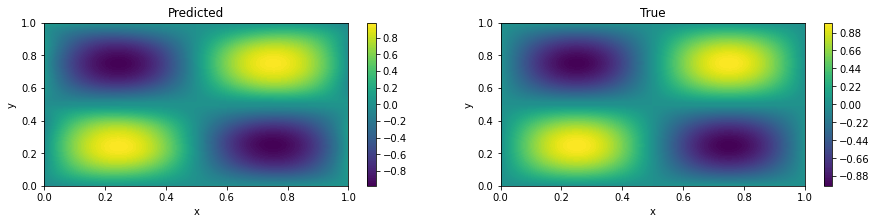

In [157]:
plt.figure(1);
fig, ax = plt.subplots(1, 2, figsize=(15,3));
pl0 = ax[0].contourf(x.detach().numpy(), np.linspace(0,1, 2*n_train),u_p,100)
ax[0].set(xlabel = 'x', ylabel = 'y',title='Predicted');
pl1 = ax[1].contourf(x.detach().numpy(), np.linspace(0,1, 2*n_train),u_t,100)
ax[1].set(xlabel = 'x', ylabel = 'y',title='True');
fig.colorbar(pl0,ax=ax[0]); fig.colorbar(pl1,ax=ax[1]);